# Convolutional Neural Networks

<img src="https://www.cntk.ai/jup/cntk103d_conv2d_final.gif" width=175px>


## Setup

Using the Keras library to import the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset due to the simplicity over other libraries (e.x. [CNTK](https://cntk.ai/pythondocs/CNTK_103A_MNIST_DataLoader.html#) and [TensorFlow](https://www.tensorflow.org/get_started/mnist/pros))
<img src="https://upload.wikimedia.org/wikipedia/commons/2/27/MnistExamples.png", width=400px>

In [1]:
import keras
from keras import backend as K
import matplotlib.pyplot as plt

%matplotlib inline

# Loading the data, shuffled and split between train and test sets
(X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()

# Input image dimensions
img_rows, img_cols = 28, 28
num_channels = 1

# Ensuring the channels are in the correct 
if K.image_data_format() == 'channels_first':
    X_train = X_train.reshape(X_train.shape[0], num_channels, img_rows, img_cols)
    X_test = X_test.reshape(X_test.shape[0], num_channels, img_rows, img_cols)
    input_shape = (num_channels, img_rows, img_cols)
else:
    X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, num_channels)
    X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, num_channels)
    input_shape = (img_rows, img_cols, num_channels)
    
print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'Training samples')
print(X_test.shape[0], 'Testing samples')

Using TensorFlow backend.


X_train shape: (60000, 28, 28, 1)
60000 Training samples
10000 Testing samples


## Keras

In [2]:
import sys
import time
import numpy as np
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import advanced_activations
from keras.layers.normalization import BatchNormalization
from keras import callbacks
from keras import backend as K

print(time.strftime('%Y/%m/%d %H:%M'))
print('OS:', sys.platform)
print('Python:', sys.version)
print('NumPy:', np.__version__)
print('Keras:', keras.__version__)

# Printing backend and GPU information
if keras.backend.backend() == 'tensorflow':
    import tensorflow as tf
    from tensorflow.python.client import device_lib
    print('Backend: TensorFlow', tf.__version__)
    local_device_protos = device_lib.list_local_devices()
    print([x for x in local_device_protos if x.device_type == 'GPU'])

    # Avoiding memory issues with the GPU
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    sess = tf.Session(config=config)
    K.set_session(sess)

elif keras.backend.backend() == 'cntk':
    import cntk as C
    print('Backend: CNTK', C.__version__)
    print('GPU: ', C.gpu(0))

# Setting data types and normalizing the images
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255
print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'Training samples')
print(X_test.shape[0], 'Testing samples')

# Model settings
batch_size = 128
num_classes = 10
epochs = 12

# Converting class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)


# Beginning model building
model = Sequential()

# Layer 1 - Conv (5x5)
model.add(Conv2D(32, kernel_size=(5, 5), input_shape=input_shape))
model.add(advanced_activations.LeakyReLU(alpha=0.03))

# Layer 2 - Conv (5x5) & Max Pooling
model.add(Conv2D(32, kernel_size=(5, 5)))
model.add(advanced_activations.LeakyReLU(alpha=0.03))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))

# Layer 3 - Conv (3x3)
model.add(Conv2D(64, kernel_size=(3, 3)))
model.add(advanced_activations.LeakyReLU(alpha=0.03))

# Layer 4 - Conv (3x3) & Max Pooling
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(advanced_activations.LeakyReLU(alpha=0.03))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))

# Layer 5 - FC 1024
model.add(Flatten())
model.add(Dense(1024, activation='relu'))

# Layer 6 - FC 1024
model.add(Dense(1024, activation='relu'))

# Output Layer
model.add(Dense(num_classes, activation='softmax'))

# Defining loss function, optimizer, and metrics to report
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

# Summary of the model before fitting
model.summary()


### Setting up callbacks
# Early stopping
earlystop = callbacks.EarlyStopping(monitor='val_loss',
                                    min_delta=0.0001,  # Amount counting as an improvement
                                    patience=5,  # Number of epochs before stopping
                                    verbose=1, 
                                    mode='auto')

# Tracking the training time for each epoch
class TimeHistory(callbacks.Callback):
    '''
    Tracks training time on individual epochs for a Keras model
    '''
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, batch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, batch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)

        
time_callback = TimeHistory()  # Gives training time for all epochs


# Model checkpoints - saves the model with the best validation loss
model_filepath = 'model.val_loss{val_loss:.5f}_epoch{epoch:04d}-.h5'
checkpoint = callbacks.ModelCheckpoint(model_filepath, monitor='val_loss',
                                       save_best_only=True)

# Reducing the learning rate if training loss does not increase
learning_rate_redux = callbacks.ReduceLROnPlateau(monitor='loss', 
                                                  patience=3,  # Reduce after 3 epochs
                                                  verbose=1, 
                                                  factor=0.3,  # Reduce to 1/3
                                                  min_lr=0.00001)


# Fitting the model
model_info = model.fit(X_train, y_train,
                       epochs=epochs,
                       batch_size=batch_size, verbose=1,
                       validation_split=0.1,  # Uses last 10% of data (not shuffled) for validation
                       callbacks=[earlystop, checkpoint, learning_rate_redux, time_callback])

# Getting test information
score, acc = model.evaluate(X_test, y_test,
                            batch_size=batch_size)
print()
print('Test score:', score)
print('Test accuracy:', acc)

# Saving the model
# model.save('model.h5')

# Reporting total training time
total_training_time = round(sum(time_callback.times))
print('Total training time for {0} epochs: {1} seconds'.format(epochs, total_training_time))

2018/04/28 20:31
OS: win32
Python: 3.6.2 |Anaconda custom (64-bit)| (default, Jul 20 2017, 12:30:02) [MSC v.1900 64 bit (AMD64)]
NumPy: 1.12.1
Keras: 2.0.6
Backend: TensorFlow 1.3.0
[name: "/gpu:0"
device_type: "GPU"
memory_limit: 1524796620
locality {
  bus_id: 1
}
incarnation: 17807082595901432932
physical_device_desc: "device: 0, name: GeForce GTX 680, pci bus id: 0000:01:00.0"
]
X_train shape: (60000, 28, 28, 1)
60000 Training samples
10000 Testing samples
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 24, 24, 32)        832       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 20, 20, 32)        25632     
_________________________________________________________________
leaky_r

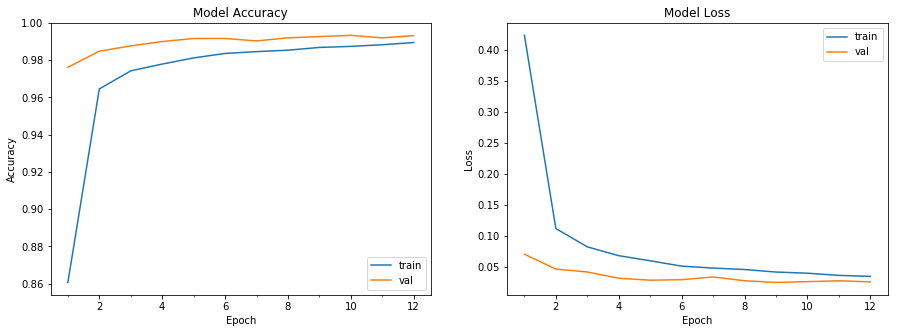

In [4]:
def plot_model_loss_acc(model_history):
    '''
    Plots the accuracy and the loss for the training and
    validation sets by epoch
    '''
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    
    # Accuracy plot
    axs[0].plot(range(1, len(model_history.history['acc'])+1),
                      model_history.history['acc'])
    axs[0].plot(range(1, len(model_history.history['val_acc'])+1), 
                      model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1, len(model_history.history['acc'])+1), 
                                len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    
    # Loss plot
    axs[1].plot(range(1, len(model_history.history['loss'])+1),
                      model_history.history['loss'])
    axs[1].plot(range(1, len(model_history.history['val_loss'])+1),
                      model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1, len(model_history.history['loss'])+1),
                                len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()
    

plot_model_loss_acc(model_info)

### Data Augmentation

Using Keras functionality for training on augmented data

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

datagenerator = ImageDataGenerator(
        rotation_range=360,
        width_shift_range=0.2,
        height_shift_range=0.2,
        rescale=None,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest')

datagenerator.fit(X_train)

# Fit the model on the batches generated by datagen.flow().
model_info = model.fit_generator(generator=datagenerator.flow(X_train, y_train,
                                                              batch_size=batch_size,
                                                              shuffle=True),
                                 steps_per_epoch=10*round(X_train.shape[0] / batch_size),
                                 epochs=epochs,
                                 validation_data=(X_val, y_val),
                                 verbose=1,
                                 callbacks=[time_callback,  # Gives epoch training times
                                            earlystop,
                                            callbacks.ModelCheckpoint('model.h5', save_best_only=True)])

### Additional Setup

Splitting the training dataset into training and validation since Keras automatically does this when fitting the model

In [2]:
from sklearn.model_selection import train_test_split
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=.2)

## CNTK

**To-do: **
- Finish CNTK script to train the model
- Add script for loading trained model and generating predictions

In [3]:
import sys
import time
import numpy as np
import cntk as C
from cntk.layers import Convolution2D, MaxPooling, Dropout, Dense

print(time.strftime('%Y/%m/%d %H:%M'))
print('OS:', sys.platform)
print('Python:', sys.version)
print('NumPy:', np.__version__)
print('CNTK:', C.__version__)
print('GPU:', C.gpu(0))

2018/03/22 18:00
OS: win32
Python: 3.6.2 |Anaconda custom (64-bit)| (default, Jul 20 2017, 12:30:02) [MSC v.1900 64 bit (AMD64)]
NumPy: 1.13.3
CNTK: 2.3.1
GPU: GPU[0] GeForce GTX 680


Reference [1](https://github.com/Microsoft/CNTK/blob/master/Examples/Image/Classification/ConvNet/Python/ConvNet_MNIST.py) | [2](https://cntk.ai/pythondocs/CNTK_103D_MNIST_ConvolutionalNeuralNetwork.html) | [3](https://medium.com/@tuzzer/building-a-deep-handwritten-digits-classifier-using-microsoft-cognitive-toolkit-6ae966caec69)

In [26]:
# Define the data dimensions
input_dim_model = (1, 28, 28)  # Images are 28 x 28 with 1 channel of color (gray)
input_dim = 28*28  # used by readers to treat input data as a vector
num_output_classes = 10

X = C.input_variable(input_dim_model)
y = C.input_variable(num_output_classes)

def create_model(input_vars, out_dims=10, dropout_prob=0.0):
    with C.layers.default_options(init=C.glorot_uniform(), activation=C.relu):

        conv1 = Convolution2D(filter_shape=(5, 5),
                            num_filters=8,
                            strides=(2, 2),
                            pad=True,
                            init_bias=0.1,
                            name='conv1')(input_vars)
        pooling1 = MaxPooling((2, 2),
                              strides=(2, 2),
                              pad=True)(conv1)

        conv2 = Convolution2D(filter_shape=(5, 5),
                            num_filters=64,
                            strides=1,
                            pad=True,
                            init_bias=0.1,
                            name='conv2')(pooling1)
        pooling2 = MaxPooling((2, 2),
                              strides=(2, 2),
                              pad=True)(conv2)

        fc1 = Dense(1024,
                    init_bias=0.1,
                    name='fc1')(pooling2)
        
        dropout1 = Dropout(dropout_prob)(fc1)
        
        output_layer = Dense(out_dims,
                             activation=None,
                             init_bias=0.1,
                             name='classify')(dropout1)

        return output_layer
        
# Defining the input to the neural network
input_vars = C.input_variable(input_dim, np.float32)
        
# Create the model
output = create_model(X)

# Print the output shapes / parameters of different components
print('Output Shape of the first convolution layer:', output.conv1.shape)
print('Bias value of the last dense layer:', output.classify.b.value)

# Number of parameters in the network
C.logging.log_number_of_parameters(output)

### Setting up the trainer
# Define the label as the other input parameter of the trainer
labels = C.input_variable(num_output_classes, np.float32)

# Initialize the parameters for the trainer
train_minibatch_size = 50
# lr_schedule = C.learners.learning_parameter_schedule_per_sample(lr_per_sample, epoch_size=epoch_size)
momentum = 0.9

# Define the loss function
loss = C.cross_entropy_with_softmax(output, labels)

# Define the function that calculates classification error
label_error = C.classification_error(output, labels)

# Instantiate the trainer object to drive the model training
# learner = C.learners.momentum_sgd(output.parameters, lr_schedule, momentum)
# trainer = C.Trainer(output, loss, label_error, [learner])

Output Shape of the first convolution layer: (8, 14, 14)
Bias value of the last dense layer: [ 0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1]
Training 1072922 parameters in 8 parameter tensors.


### Testing

Below is non-working code being saved here so I can use pull this notebook on other machines

In [72]:
LR = 0.01
MOMENTUM = 0.9
batch_size = 128


def shuffle_data(X, y):
    s = np.arange(len(X))
    np.random.shuffle(s)
    X = X[s]
    y = y[s]
    return X, y

def yield_mb(X, y, batchsize=128, shuffle=False):
    if shuffle:
        X, y = shuffle_data(X, y)
    # Only complete batches are submitted
    for i in range(len(X) // batchsize):
        yield X[i * batchsize:(i + 1) * batchsize], y[i * batchsize:(i + 1) * batchsize]


# def create_symbol(n_classes=10):
#     # Weight initialiser from uniform distribution
#     # Activation (unless states) is None
#     with C.layers.default_options(init = C.glorot_uniform(), activation = C.relu):
#         x = Convolution2D(filter_shape=(5, 5), num_filters=32, pad=True)(features)
#         x = Convolution2D(filter_shape=(5, 5), num_filters=32, pad=True)(x)
#         x = MaxPooling((2, 2), strides=(2, 2), pad=False)(x)
#         x = Dropout(0.25)(x)

#         x = Convolution2D(filter_shape=(3, 3), num_filters=100, pad=True)(x)
#         x = Convolution2D(filter_shape=(3, 3), num_filters=100, pad=True)(x)
#         x = MaxPooling((2, 2), strides=(2, 2), pad=False)(x)
#         x = Dropout(0.25)(x)    
        
#         x = Dense(512)(x)
#         x = Dropout(0.5)(x)
#         x = Dense(n_classes, activation=None)(x)
#         return x
    
    
# X = C.input_variable(input_dim_model)
# y = C.input_variable(num_output_classes)

def create_symbol(out_dims=10, dropout_prob=0.0):
    with C.layers.default_options(init=C.glorot_uniform(), activation=C.relu):
        conv1 = Convolution2D(filter_shape=(5, 5),
                            num_filters=8,
                            strides=(2, 2),
                            pad=True,
                            init_bias=0.1,
                            name='conv1')(features)
        pooling1 = MaxPooling((2, 2),
                              strides=(2, 2),
                              pad=True)(conv1)

        conv2 = Convolution2D(filter_shape=(5, 5),
                            num_filters=64,
                            strides=1,
                            pad=True,
                            init_bias=0.1,
                            name='conv2')(pooling1)
        pooling2 = MaxPooling((2, 2),
                              strides=(2, 2),
                              pad=True)(conv2)

        fc1 = Dense(1024,
                    init_bias=0.1,
                    name='fc1')(pooling2)
        
        dropout1 = Dropout(dropout_prob)(fc1)
        
        output_layer = Dense(out_dims,
                             activation=None,
                             init_bias=0.1,
                             name='classify')(dropout1)

        return output_layer
    
def init_model(m, labels, lr=LR, momentum=MOMENTUM):
    # Loss (dense labels); check if support for sparse labels
    loss = C.cross_entropy_with_softmax(m, labels)  
    # Momentum SGD
    # https://github.com/Microsoft/CNTK/blob/master/Manual/Manual_How_to_use_learners.ipynb
    # unit_gain=False: momentum_direction = momentum*old_momentum_direction + gradient
    # if unit_gain=True then ...(1-momentum)*gradient
    learner = C.momentum_sgd(m.parameters,
                                lr=C.learning_rate_schedule(lr, C.UnitType.minibatch),
                                momentum=C.momentum_schedule(momentum), 
                                unit_gain=False)
    trainer = C.Trainer(m, (loss, C.classification_error(m, labels)), [learner])
    return trainer


# Placeholders
# [128 x 28 x 28 x 1
# features = C.input_variable((3, 32, 32), np.float32)
features = C.input_variable((28, 28), np.float32)
labels = C.input_variable(10, np.float32)
# Load symbol
sym = create_symbol()

trainer = init_model(sym, labels)

y_train_onehot = np.eye(len(np.unique(y_train)))[y_train]

# Main training loop: 53s
for j in range(3):
    for data, label in yield_mb(X_train.astype('float32'), y_train_onehot.astype('float32'), batch_size, shuffle=True):
        trainer.train_minibatch({features: data, labels: label})
    # Log (this is just last batch in epoch, not average of batches)
    eval_error = trainer.previous_minibatch_evaluation_average
    print("Epoch %d  |  Accuracy: %.6f" % (j+1, (1-eval_error)))
    
    
# learner = C.sgd(model.parameters,
#                 C.learning_parameter_schedule(0.1))
# progress_writer = C.logging.ProgressPrinter(0)

# train_summary = loss.train((X_train_lr, Y_train_lr), parameter_learners=[learner],
#                    callbacks=[progress_writer])

## MXNet

**To-do:**
- Add script for training a model in MXNet
- Add script for loading a trained model and generating predictions

## PyTorch

**To-do:**
- Conform model architecture to other models
- Add script for loading a trained model and generating predictions
- Add train/validation accuracy

In [10]:
import sys
import time
import numpy as np
import torch
import torch.nn as nn
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torch.autograd import Variable

print(time.strftime('%Y/%m/%d %H:%M'))
print('OS:', sys.platform)
print('Python:', sys.version)
print('NumPy:', np.__version__)
print('PyTorch:', torch.__version__)
if torch.cuda.is_available() == True:
    print('GPU:', torch.cuda.current_device())
    
    
# Checking if there is a GPU and assigning it to a variable
if torch.cuda.is_available() == True:
    gpu = True
else:
    gpu = False

# Hyper Parameters
num_epochs = 5
batch_size = 100
learning_rate = 0.001

# MNIST Dataset
train_dataset = dsets.MNIST(root='./data/',
                            train=True, 
                            transform=transforms.ToTensor(),
                            download=True)

test_dataset = dsets.MNIST(root='./data/',
                           train=False, 
                           transform=transforms.ToTensor())

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size, 
                                          shuffle=False)

# CNN Model (2 conv layer)
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=5, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2))
        self.fc = nn.Linear(7*7*32, 10)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out
        
cnn = CNN()

if gpu == True:
    cnn.cuda()


# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cnn.parameters(), lr=learning_rate)

# Train the Model
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        
        if gpu == True:
            images = Variable(images).cuda()
            labels = Variable(labels).cuda()
        else:
            images = Variable(images)
            labels = Variable(labels)
        
        # Forward + Backward + Optimize
        optimizer.zero_grad()
        outputs = cnn(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print ('Epoch [%d/%d], Iter [%d/%d] Loss: %.4f' 
                   %(epoch+1, num_epochs, i+1, len(train_dataset)//batch_size, loss.data[0]))

# Test the Model
cnn.eval()  # Change model to 'eval' mode (BN uses moving mean/var).
correct = 0
total = 0
for images, labels in test_loader:
    if gpu == True:
        images = Variable(images).cuda()
    else:
        images = Variable(images)
    outputs = cnn(images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum()

print('Test Accuracy of the model on the 10000 test images: %d %%' % (100.0 * correct / total))

# Save the Trained Model
# torch.save(cnn.state_dict(), 'cnn.pkl')

2018/02/06 13:20
OS: linux
Python: 3.5.2 (default, Aug 18 2017, 17:48:00) 
[GCC 5.4.0 20160609]
NumPy: 1.14.0
PyTorch: 0.3.0.post4
Epoch [1/5], Iter [100/600] Loss: 0.1559
Epoch [1/5], Iter [200/600] Loss: 0.2541
Epoch [1/5], Iter [300/600] Loss: 0.1078
Epoch [1/5], Iter [400/600] Loss: 0.0419
Epoch [1/5], Iter [500/600] Loss: 0.0725
Epoch [1/5], Iter [600/600] Loss: 0.1366
Epoch [2/5], Iter [100/600] Loss: 0.0406
Epoch [2/5], Iter [200/600] Loss: 0.0233
Epoch [2/5], Iter [300/600] Loss: 0.0631
Epoch [2/5], Iter [400/600] Loss: 0.0380
Epoch [2/5], Iter [500/600] Loss: 0.0049
Epoch [2/5], Iter [600/600] Loss: 0.0495
Epoch [3/5], Iter [100/600] Loss: 0.0103
Epoch [3/5], Iter [200/600] Loss: 0.0652
Epoch [3/5], Iter [300/600] Loss: 0.0153
Epoch [3/5], Iter [400/600] Loss: 0.0650
Epoch [3/5], Iter [500/600] Loss: 0.0205
Epoch [3/5], Iter [600/600] Loss: 0.0374
Epoch [4/5], Iter [100/600] Loss: 0.0126
Epoch [4/5], Iter [200/600] Loss: 0.0348
Epoch [4/5], Iter [300/600] Loss: 0.0123
Epoch [4

## TensorFlow

**To-do:**
- Conform architecture to others in the notebook

In [3]:
import sys
import time
from datetime import datetime
import numpy as np
import tensorflow as tf

print(time.strftime('%Y/%m/%d %H:%M'))
print('OS:', sys.platform)
print('Python:', sys.version)
print('NumPy:', np.__version__)
print('TensorFlow:', tf.__version__)

# Checking tensorflow processing devices
from tensorflow.python.client import device_lib
local_device_protos = device_lib.list_local_devices()
print([x for x in local_device_protos if x.device_type == 'GPU'])

# Avoiding memory issues with the GPU
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)

image_size = 28
num_labels = 10
num_channels = 1


def reformat(dataset, labels):
    dataset = dataset.reshape((-1, image_size * image_size)).astype(np.float32)
    labels = (np.arange(num_labels) == labels[:, None]).astype(np.float32)
    return dataset, labels


def accuracy(predictions, labels):
    return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
            / predictions.shape[0])


X_train, y_train = reformat(X_train, y_train)
X_validation, y_validation = reformat(X_validation, y_validation)
X_test, y_test = reformat(X_test, y_test)
print('Reformatted data shapes:')
print('Training set', X_train.shape, y_train.shape)
print('Validation set', X_validation.shape, y_validation.shape)
print('Test set', X_test.shape, y_test.shape)

# Training Parameters
learning_rate = 0.001
num_steps = y_train.shape[0] + 1  # 200,000 per epoch
batch_size = 128
epochs = 12
display_step = 250  # To print progress

# Network Parameters
num_input = 784  # Data input (image shape: 28x28)
num_classes = 10  # Total classes (10 characters)

num_hidden = 1024

# Defining the model and graph
sgd_hidden_graph = tf.Graph()
with sgd_hidden_graph.as_default():
    tf_train_dataset = tf.placeholder(
        tf.float32, shape=(batch_size, image_size * image_size))
    tf_train_labels = tf.placeholder(
        tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(X_validation.astype('float32'))
    tf_test_dataset = tf.constant(X_test, name='test_data')

    w0 = tf.Variable(tf.truncated_normal(
        [image_size * image_size, num_hidden]), name='W0')
    w1 = tf.Variable(tf.truncated_normal([num_hidden, num_labels]), name='W1')

    b0 = tf.Variable(tf.zeros([num_hidden]), name='b0')
    b1 = tf.Variable(tf.zeros([num_labels]), name='b1')

    def reluLayer(dataset):
        return tf.nn.relu(tf.matmul(dataset, w0) + b0)

    def logitLayer(dataset):
        return tf.matmul(reluLayer(dataset), w1) + b1

    sgd_hidden_loss = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(
            labels=tf_train_labels,
            logits=logitLayer(tf_train_dataset)))
    sgd_hidden_optimizer = tf.train.GradientDescentOptimizer(
        0.5).minimize(sgd_hidden_loss)

    sgd_hidden_train_prediction = tf.nn.softmax(
        logitLayer(tf_train_dataset), name='train_predictor')
    sgd_hidden_valid_prediction = tf.nn.softmax(
        logitLayer(tf_valid_dataset), name='validate_predictor')
    sgd_hidden_test_prediction = tf.nn.softmax(
        logitLayer(tf_test_dataset), name='test_predictor')


# Creating the graph and running the model
with tf.Session(graph=sgd_hidden_graph) as sgd_hidden_session:
    saver = tf.train.Saver()
    tf.global_variables_initializer().run()

    # For tracking execution time and progress
    start_time = time.time()
    total_steps = 0

    print('\nInitialized\n')
    try:
        for epoch in range(1, epochs + 1):
            print('Beginning Epoch {0} -'.format(epoch))
            for step in range(num_steps):
                offset = (step * batch_size) % (y_train.shape[0] - batch_size)
                batch_data = X_train[offset:(offset + batch_size), :]
                batch_labels = y_train[offset:(
                    offset + batch_size), :].reshape(batch_size, num_labels)
                feed_dict = {tf_train_dataset: batch_data,
                             tf_train_labels: batch_labels}
                _, l, sgd_hidden_predictions = sgd_hidden_session.run(
                    [sgd_hidden_optimizer, sgd_hidden_loss, sgd_hidden_train_prediction],
                    feed_dict=feed_dict)
                if (step % 1000 == 0) or (step == num_steps):
                    # Calculating percentage of completion
                    total_steps += step
                    pct_epoch = (step / float(num_steps)) * 100
                    pct_total = (total_steps / float(num_steps *
                                                     (epochs + 1))) * 100  # Fix this line

                    # Printing progress
                    print('Epoch %d Step %d (%.2f%% epoch, %.2f%% total)' %
                          (epoch, step, pct_epoch, pct_total))
                    print('------------------------------------')
                    print('Minibatch loss: %f' % l)
                    print("Minibatch accuracy: %.1f%%" %
                          accuracy(sgd_hidden_predictions, batch_labels))
                    print("Validation accuracy: %.1f%%" % accuracy(sgd_hidden_valid_prediction.eval(),
                                                                   y_validation))
                    print(datetime.now())
                    print('Total execution time: %.2f minutes' %
                          ((time.time() - start_time) / 60.))
                    print()
        print("Test accuracy: %.1f%%" % accuracy(
            sgd_hidden_test_prediction.eval(), y_test.astype('int32')))
    except KeyboardInterrupt:
        print('Training manually ended')
#     saver.save(sgd_hidden_session, '{}/model'.format(Path.cwd()))

2018/03/20 17:36
OS: win32
Python: 3.6.2 |Anaconda custom (64-bit)| (default, Jul 20 2017, 12:30:02) [MSC v.1900 64 bit (AMD64)]
NumPy: 1.13.3
TensorFlow: 1.3.0
[name: "/gpu:0"
device_type: "GPU"
memory_limit: 1524796620
locality {
  bus_id: 1
}
incarnation: 12763196243698338072
physical_device_desc: "device: 0, name: GeForce GTX 680, pci bus id: 0000:01:00.0"
]
Reformatted data shapes:
Training set (48000, 784) (48000, 10)
Validation set (12000, 784) (12000, 10)
Test set (10000, 784) (10000, 10)

Initialized

Beginning Epoch 1 -
Epoch 1 Step 0 (0.00% epoch, 0.00% total)
------------------------------------
Minibatch loss: 62305.937500
Minibatch accuracy: 10.2%
Validation accuracy: 10.2%
2018-03-20 17:36:26.054341
Total execution time: 0.01 minutes

Epoch 1 Step 1000 (2.08% epoch, 0.16% total)
------------------------------------
Minibatch loss: 2.296496
Minibatch accuracy: 13.3%
Validation accuracy: 10.5%
2018-03-20 17:36:29.352841
Total execution time: 0.06 minutes

Epoch 1 Step 2000

### Loading in a trained model and generating predictions

Most of this script is from a competition submission script and needs to be cleaned up. Additionally, it contains code for creating a pickle file from images within subdirectories.

In [ ]:
from six.moves import cPickle as pickle
from scipy import ndimage
import math
import numpy as np
import os
from pathlib import Path
from __future__ import print_function
import tensorflow as tf
from pathlib import Path

# Change this line to the saved model
modelFile = 'trainedModel.meta'

image_size = 28  # Pixel width and height.
num_labels = 10
pixel_depth = 255.0  # Number of levels per pixel.

total_images = sum([len(files) for r, d, files in os.walk("./data/")])


def accuracy(predictions, labels):
    return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
            / predictions.shape[0])


def load_letter(folder, min_num_images):
    """Load the data for a single letter label."""
    image_files = list(folder.iterdir())
    dataset = np.ndarray(shape=(len(image_files), image_size, image_size),
                         dtype=np.float32)
    print(folder)
    num_images = 0
    for image in image_files:
        image_file = folder.joinpath(image)
        try:
            image_data = (ndimage.imread(image_file).astype(float) -
                          pixel_depth / 2) / pixel_depth
            if image_data.shape != (image_size, image_size):
                raise Exception('Unexpected image shape: %s' %
                                str(image_data.shape))
            dataset[num_images, :, :] = image_data
            num_images = num_images + 1
        except IOError as e:
            print('Could not read:', image_file,
                  ':', e, '- it\'s ok, skipping.')

    dataset = dataset[0:num_images, :, :]
    if num_images < min_num_images:
        raise Exception('Many fewer images than expected: %d < %d' %
                        (num_images, min_num_images))

    print('Full dataset tensor:', dataset.shape)
    print('Mean:', np.mean(dataset))
    print('Standard deviation:', np.std(dataset))
    return dataset


def maybe_pickle(data_folders, min_num_images_per_class, force=False):
    dataset_names = []
    data_folders = (i for i in data_folders if i.is_dir())
    for folder in data_folders:
        set_filename = str(folder) + '.pickle'
        dataset_names.append(set_filename)
        if os.path.exists(set_filename) and not force:
            # You may override by setting force=True.
            print('%s already present - Skipping pickling.' % set_filename)
        else:
            print('Pickling %s.' % set_filename)
            dataset = load_letter(folder, min_num_images_per_class)
            try:
                with open(set_filename, 'wb') as f:
                    pickle.dump(dataset, f, pickle.HIGHEST_PROTOCOL)
            except Exception as e:
                print('Unable to save data to', set_filename, ':', e)
    return dataset_names


def make_arrays(nb_rows, img_size):
    if nb_rows:
        dataset = np.ndarray((nb_rows, img_size, img_size), dtype=np.float32)
        labels = np.ndarray(nb_rows, dtype=np.int32)
    else:
        dataset, labels = None, None
    return dataset, labels


def randomize(dataset, labels):
    permutation = np.random.permutation(labels.shape[0])
    shuffled_dataset = dataset[permutation, :, :]
    shuffled_labels = labels[permutation]
    return shuffled_dataset, shuffled_labels


def reformat(dataset, labels):
    dataset = dataset.reshape(
        labels.shape[0], image_size, image_size, 1).astype(np.float32)
    labels = (np.arange(num_labels) == labels[:, None]).astype(np.float32)
    return dataset, labels


def merge_datasets(pickle_files, dataset_size):
    """
    Merge multiple glyph pickle files into nd-array dataset and nd-array labels
    for model evaluation.
    Simplification from https://github.com/udacity/deep-learning
    """
    num_classes = len(pickle_files)
    dataset, labels = make_arrays(dataset_size, image_size)
    size_per_class = dataset_size // num_classes

    start_t = 0
    for label, pickle_file in enumerate(pickle_files):
        try:
            with open(pickle_file, 'rb') as f:
                letter_set = pickle.load(f)
                end_t = start_t + size_per_class
                np.random.shuffle(letter_set)
                dataset[start_t:end_t, :, :] = letter_set[0:size_per_class]
                labels[start_t:end_t] = label
                start_t = end_t
        except Exception as e:
            print('Unable to process data from', pickle_file, ':', e)
            raise

    return dataset, labels


dir_name = 'data'

glyph_dir = Path.cwd().joinpath(dir_name)
test_folders = [glyph_dir.joinpath(i) for i in glyph_dir.iterdir()]
test_datasets = maybe_pickle(test_folders, 2)  # provide only 2 samples for now
test_dataset, test_labels = merge_datasets(test_datasets, total_images)
test_dataset, test_labels = randomize(test_dataset, test_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
print('Testing size', test_dataset.shape, test_labels.shape)


def classify(test_dataset, model_filename=modelFile, checkpoint_path=None):
    """
    A sample classifier to unpickle a TensorFlow model and label the dataset.
    There are magic strings in this function derived from to the model to evaluate.
    Your implementation will likely have different tags that depend upon the model
    implementation.

    We pad the input test_dataset to make it at least as large as the model batch,
    and repeat prediction on chunks of the input if it is larger than the model batch.

    Args:
        test_dataset: Expect an input of N*28*28*1 shape numpy array, where N is number of images and
                      28*28 is pixel width and hieght.
        model_filename: optional file name stored by a previous TensorFlow session.
        checkpoint_path: optional path for previous TensorFlow session.

    Returns:
        The #observations by #labels nd-array labelings.
    """
    # Re-scaling the dataset to a similar scale as the training data in the notMNIST.pickle file
    pixel_depth = 255.0
    test_dataset = (test_dataset - 255.0 / 2) / 255

    num_classes = 10
    n = int(test_dataset.shape[0])
    result = np.ndarray([n, num_classes], dtype=np.float32)

    with tf.Session() as session:
        saver = tf.train.import_meta_graph('./model/' + model_filename)
        saver.restore(session, './model/' + model_filename.split('.')[0])
        graph_predict = tf.get_default_graph()
        test_predict = graph_predict.get_tensor_by_name(
            'Softmax_1:0')  # string from model
        m = int(graph_predict.get_tensor_by_name(
            'Placeholder:0').shape[0])   # string from model
        for i in range(0, int(math.ceil(n / m))):
            start = i * m
            end = min(n, ((i + 1) * m))
            x = np.zeros((128, 28, 28, 1)).astype(np.float32)
            x[0:(end - start)] = test_dataset[start:end]
            result[start:end] = test_predict.eval(
                feed_dict={"Placeholder:0": x})[0:(end - start)]
    return result


def testing_accuracy(data, labels):
    """
    Generates predictions and returns the accuracy
    """
    predictions = classify(data)
    print("Test accuracy: %.1f%%" % accuracy(predictions, labels))


testing_accuracy((test_dataset), test_labels)